In [2]:
from sklearn.neural_network import MLPClassifier
import numpy as np 
from numpy.random import default_rng
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl 
import math
import random
from scipy.stats import multivariate_normal
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.preprocessing import MinMaxScaler






In [3]:
# Generate Data
def generate_data(N):
    '''
    Generate N samples according to a multivariate Gaussian probability density function, 
    keeping track of the true class labels for each sample. 
    Parameters
    ----------
    The mus, covs, and cps of the Gaussian distributions in array form
    Returns
    -------
    samples: numpy.array
        The generated sample data
    '''
    # 4 classes
    # p = 0.25 for each class
    # 3d gaussian pdf
    priors = [0.25, 0.25, 0.25, 0.25]
    mu0 = [1,  1,  1]
    mu1 = [1, -1,  1]
    mu2 = [1, -1, -1]
    mu3 = [1,  1, -1]
    mus = [mu0,mu1,mu2,mu3]
    n=3
    mus = np.array([1*np.ones(n), 4*np.ones(n), 6*np.ones(n), 9*np.ones(n)])
    cov0 = [[1, 0.5, 0],
            [0, 1, 1],
            [1, 1, 0]]
    cov1 = [[0.5, 0,   1],
            [1.2, 1,   0.8],
            [1,   0.6, 0]]
    cov2 = [[1, 0.5, 1],
            [1, 1, 1],
            [1, 1, 1]]
    cov3 = [[0.5, 0.5, 0.5],
            [1.4, 1.2, 0.7],
            [0.6, 1.1, 0.5]]
    sigmas = [cov0,cov1,cov2,cov3]
    sigmas = np.array([2*np.eye(n), 2*np.eye(n), 2*np.eye(n), 2*np.eye(n)])
    rng = default_rng()
    overall_size = N
    priors = np.cumsum(priors)
    size0 = 0
    size1 = 0
    size2 = 0
    size3 = 0
    for i in range(0, overall_size) :
        r = random.random()
        if(r < priors[0]):
            size0 = size0 + 1
        elif(r < priors[1]):
            size1 = size1 + 1
        elif(r < priors[2]):
            size2 = size2 + 1
        else:
            size3 = size3 + 1

    samples0 = rng.multivariate_normal(mean=mus[0], cov=sigmas[0], size=size0)
    samples0 = pd.DataFrame(samples0, columns=['x','y','z'])
    samples0['True Class Label'] = 0

    samples1 = rng.multivariate_normal(mean=mus[1], cov=sigmas[1], size=size1)
    samples1 = pd.DataFrame(samples1, columns=['x','y','z'])
    samples1['True Class Label'] = 1

    samples2 = rng.multivariate_normal(mean=mus[2], cov=sigmas[2], size=size2)
    samples2 = pd.DataFrame(samples2, columns=['x','y','z'])
    samples2['True Class Label'] = 2

    samples3 = rng.multivariate_normal(mean=mus[3], cov=sigmas[3], size=size3)
    samples3 = pd.DataFrame(samples3, columns=['x','y','z'])
    samples3['True Class Label'] = 3

    samples   = pd.concat([samples0, samples1, samples2, samples3])
    return samples

def plot_sample_data(samples):
    '''
    Plots the 3-dimensions of the samples taken from the distribution.
    Parameters
    ----------
    samples: pandas.DataFrame
        DataFrame containing the sample data
    Returns
    -------
    None
    '''
    fig = plt.figure(figsize=(5,5))
    fig.subplots_adjust(left=0.01, right=0.985, top=0.99, bottom=0.01, wspace=0)
    ax = plt.axes(projection ="3d")
    samples0 = samples[samples['True Class Label']==0]
    samples1 = samples[samples['True Class Label']==1]
    samples2 = samples[samples['True Class Label']==2]
    samples3 = samples[samples['True Class Label']==3]
    x_0 = samples0['x'].tolist()
    y_0 = samples0['y'].tolist()
    z_0 = samples0['z'].tolist()
    x_1 = samples1['x'].tolist()
    y_1 = samples1['y'].tolist()
    z_1 = samples1['z'].tolist()
    x_2 = samples2['x'].tolist()
    y_2 = samples2['y'].tolist()
    z_2 = samples2['z'].tolist()
    x_3 = samples3['x'].tolist()
    y_3 = samples3['y'].tolist()
    z_3 = samples3['z'].tolist()
    ax.scatter3D(x_0, y_0, z_0, label='1', marker='+', alpha=0.2)
    ax.scatter3D(x_1, y_1, z_1, label='2', marker='o', alpha=0.2)
    ax.scatter3D(x_2, y_2, z_2, label='3', marker='^', alpha=0.2)
    ax.scatter3D(x_3, y_3, z_3, label='4', marker='s', alpha=0.2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend(loc='upper left', title='True Class Label')
    plt.show()
    plt.clf()
    return None

In [15]:
# Cross Validation using K Fold
def cross_validation(data, k=10, verbose=False):
    '''
    Cross-validation to determine best number of perceptrons
    for an MLPclassifier.
    Parameters
    ----------
    data: pd.DataFrame
        The data to use
    k: int, optional
        Number of folds; k-fold cross validation
    Returns
    -------
    P: int
        Optimal number of perceptrons.
    results: pandas.DataFrame
        Dataframe showing the probability of error and number
        of perceptrons.
    '''
    # Make k subsamples
    cv = KFold(n_splits=k)
    # Repeat the cross-validation over numerous hyparameter configurations
    Ps = [x for x in np.arange(1, 11, 1)]
    activation = 'relu'
    results = pd.DataFrame()
    X = []
    for i, row in data.iterrows():
        X.append([row['x'],row['y'],row['z']])
    for p in Ps:
        model = MLPClassifier(hidden_layer_sizes=(p,), activation=activation, max_iter=4000)
        scores = cross_val_score(estimator=model, X=X, y=data['True Class Label'], cv=cv, scoring='accuracy')
        print(scores)
        p_errs = [1-score for score in scores]
        d = pd.DataFrame([{'Mean Probability of Error Score': np.mean(p_errs), 'Number of Perceptrons': p}])
        results = pd.concat([results, d], ignore_index=True)
    data = results
    results = results.sort_values(by='Mean Probability of Error Score').iloc[0]
    min_score = results['Mean Probability of Error Score']
    if(verbose):
        print('The minimum-average-cross-validation-probability-of-error is: %.3f'%min_score)
    return results['Number of Perceptrons'], data

def plot_cross_validation_results(data):
    '''
    Plot how the hyperparameter changes the cross validation results.
    Parameters
    ----------
    Data: pd.DataFrame
        Data on the cross validation previously done.
    
    Returns
    -------
    None
    '''
    fig, ax = plt.subplots(1,1,figsize=(5,2.8))
    fig.subplots_adjust(left=0.11, right=0.985, top=0.98, bottom=0.16, wspace=0)
    data['Training Dataset Size'] = data['Training Dataset Size'].astype(str)
    sns.scatterplot(data=data, x='Number of Perceptrons', y='Mean Probability of Error Score', hue='Training Dataset Size', palette='ch:s=-.2,r=.6')
    ax.set_ylim(0,1)
    plt.savefig('./q1_cross_validation.pdf')
    plt.clf()
    plt.close()
    return None

In [ ]:
# Hyperparameter testing?
def test_hyperparameters(train_data, test_data, p):
    '''
    Trains an MLP with the appropriate number of perceptrons, determined previously by
    10-fold cross validation, using the entire respective training set.
    Parameters
    ----------
    train_data: pd.DataFrame
        Data to train the model
    test_data: pd.DataFrame
        Data to test the accuracy of the model
    p: int
        Number of perceptrons to use in the model.
    Returns
    -------
    test_data: pd.DataFrame
        Predicted values and original testing data.
    '''
    # Train the model using the optimized hyperparameters
    X = []
    for i, row in train_data.iterrows():
        X.append([row['x'],row['y'],row['z']])
    Y = train_data['True Class Label']
    activation = 'relu'
    model = MLPClassifier(hidden_layer_sizes=(int(p),), activation=activation, max_iter=4000)
    model.fit(X,Y)
    # Test the accuracy of the model
    X = []
    for i, row in test_data.iterrows():
        X.append([row['x'],row['y'],row['z']])
    Y = model.predict(X)
    test_data['Predicted Label'] = Y
    return test_data

In [ ]:
# Plot Model Results and Accuracy?

def plot_model_results(data, training_size):
    '''
    Plot the accuracy of determined hyperparameters in training the model.
    Parameters
    ----------
    Data: pd.DataFrame
        Data on the model fit previously done.
    training_size: int
        Number of sample in training dataset.
    
    Returns
    -------
    None
    '''
    fig = plt.figure(figsize=(5,5))
    fig.subplots_adjust(left=0.01, right=0.985, top=0.99, bottom=0.01, wspace=0)
    ax = plt.axes(projection ="3d")
    correct = 0
    for idx,row in data.iterrows():
        if idx%10 != 0:
            continue
        true_label = row['True Class Label']
        decision   = row['Predicted Label']
        x = row['x']
        y = row['y']
        z = row['z']
        if(true_label==0.0):
            if(true_label==decision):
                ax.scatter3D(x,y,z,marker='x',color='g',alpha=0.1)
                correct = correct + 1
            else:
                ax.scatter3D(x,y,z,marker='x',color='r',alpha=0.1)
        elif(true_label==1.0):
            if(true_label==decision):
                ax.scatter3D(x,y,z,marker='o',color='g',alpha=0.1)
                correct = correct + 1
            else:
                ax.scatter3D(x,y,z,marker='o',color='r',alpha=0.1)
        elif(true_label==2.0):
            if(true_label==decision):
                ax.scatter3D(x,y,z,marker='^',color='g',alpha=0.1)
                correct = correct + 1
            else:
                ax.scatter3D(x,y,z,marker='^',color='r',alpha=0.1)
        else:
            if(true_label==decision):
                ax.scatter3D(x,y,z,marker='s',color='g',alpha=0.1)
                correct = correct + 1
            else:
                ax.scatter3D(x,y,z,marker='s',color='r',alpha=0.1)
    accuracy = correct/(data.shape[0]/10)
    print('Model accuracy was %.3f'%(accuracy))
    '''
    legend_elements = [Line2D([0], [0], marker='x', color='w', label='1', markerfacecolor='grey', markersize=15),
                        Line2D([0], [0], marker='o', color='w', label='2', markerfacecolor='grey', markersize=15),
                        Line2D([0], [0], marker='^', color='w', label='3', markerfacecolor='grey', markersize=15),
                        Line2D([0], [0], marker='s', color='w', label='4', markerfacecolor='grey', markersize=15)]
    legend0 = ax.legend(handles=legend_elements, title='True Class Label', loc='upper right')
    '''
    legend_elements = [Patch(facecolor='g', edgecolor='g', label='True'),
                        Patch(facecolor='r', edgecolor='r', label='False')]
    legend1 = ax.legend(handles=legend_elements, title='Correctly Classified', loc='lower right')
    #ax.add_artist(legend0)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
    # plt.savefig('./q1_classified_data_%d.jpg'%training_size)
    # plt.clf()
    return accuracy

def plot_accuracy(accuracy_data, test_data):
    '''
    Scatterplot of how the size of the training dataset affects the accuracy
    of the model.
    Parameters
    ----------
    data: pd.DataFrame
        Data for plotting
    Returns
    -------
    None
    '''
    # Get the theoretical optimal classification
    thy_optimal = find_optimal_classification(test_data)
    print("Theoretical optimal classification: %.3f"%thy_optimal)
    fig, ax = plt.subplots(1,1,figsize=(5,2))
    fig.subplots_adjust(left=0.13, right=0.985, top=0.97, bottom=0.23, wspace=0)
    data['Training Dataset Size'] = data['Training Dataset Size'].astype(int).astype(str)
    sns.scatterplot(data=data, x='Training Dataset Size', y='Accuracy', palette='ch:s=-.2,r=.6')
    plt.axhline(y=thy_optimal, color='r', linestyle='--')
    ax.set_ylim(.7,.9)
    ax.yaxis.grid(color='lightgrey', linestyle=':')
    ax.set_axisbelow(True)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    plt.savefig('./q1_model_accuracy.pdf')
    plt.clf()
    plt.close()
    return None

In [33]:
# Optimal Classifier
def find_optimal_classification(data):
    X = []
    for i, row in data.iterrows():
        X.append([row['x'],row['y'],row['z']])
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    Y = data['True Class Label']
    model = GaussianNB(priors=[0.25,0.25,0.25,0.25])
    model.fit(X,Y)
    data['Predicted Label'] = model.predict(X)
    correct = 0
    for idx,row in data.iterrows():
        true_label = row['True Class Label']
        decision   = row['Predicted Label']
        if(true_label==decision):
                correct = correct + 1
    accuracy = correct/(data.shape[0])
    return accuracy

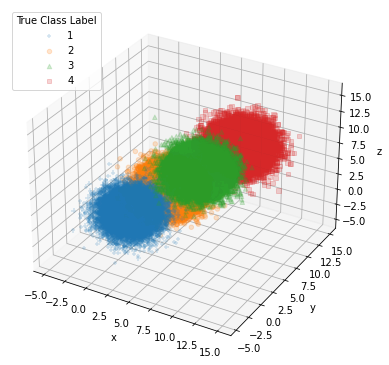

<Figure size 432x288 with 0 Axes>

In [17]:
# Generate samples
# Training datasets
train0 = generate_data(100)
train1 = generate_data(200)
train2 = generate_data(500)
train3 = generate_data(1000)
train4 = generate_data(2000)
train5 = generate_data(5000)
# Testing dataset
test = generate_data(100000)

# Plot the testing data without classification
plot_sample_data(test)

In [38]:
# Perform 10-Fold Cross-Validation - returns "best" number of perceptrons
n_perceptrons, cv_results = cross_validation(train1, k=10, verbose=False)
print("1000 CV Perceptrons: {}".format(n_perceptrons))

[0.1  0.   0.45 0.   0.45 0.   0.4  0.   0.   0.9 ]
[0.45 0.95 0.7  0.   0.45 0.85 0.   0.   0.   0.95]


c:\Users\meuli\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(


[1.   0.5  0.5  0.   0.7  0.55 0.75 1.   0.85 0.9 ]


c:\Users\meuli\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(


[1.   0.   0.7  0.7  0.9  0.8  0.7  0.95 0.7  0.85]


c:\Users\meuli\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(


[1.   0.95 0.65 0.7  0.7  0.5  0.7  0.95 0.85 0.85]
[0.95 0.95 0.7  0.65 0.7  0.75 0.7  0.95 0.8  0.85]
[1.   0.95 0.65 0.7  0.8  0.8  0.75 0.95 0.85 0.85]
[0.85 0.85 0.75 0.75 0.75 0.65 0.7  0.9  0.85 0.85]
[0.95 0.95 0.75 0.7  0.85 0.8  0.7  0.95 0.85 0.85]
[0.85 0.9  0.65 0.65 0.7  0.7  0.7  0.95 0.85 0.85]
1000 CV Perceptrons: 9.0


Model accuracy was 0.891


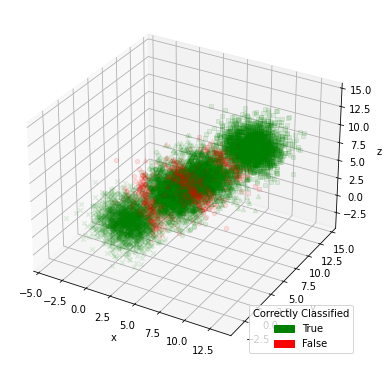

In [50]:
res = cv_results.to_numpy()
prob_error = res[:,0]
num_perceptrons = res[:,1]

min_index = np.argmin(prob_error)
min_prob_error = prob_error[min_index]
num_perceptrons_best = num_perceptrons[min_index]



training_size = 200

# Train MLP with the number of perceptrons specified above
results = test_hyperparameters(train1, test, num_perceptrons_best)
accuracy = plot_model_results(results, training_size)

In [3]:

# Find optimal hyperparameters
final_results = pd.DataFrame()
n_perceptrons, results = cross_validation(train0, k=10, verbose=False)
print("100 CV Perceptrons: %d"%n_perceptrons)
results.to_csv('./q1_cv_results_100.csv')
results["Training Dataset Size"] = 100
final_results = final_results.append(results, ignore_index=True)

n_perceptrons, results = cross_validation(train1, k=10, verbose=False)
print("200 CV Perceptrons: %d"%n_perceptrons)
results.to_csv('./q1_cv_results_200.csv')
results["Training Dataset Size"] = 200
final_results = final_results.append(results, ignore_index=True)

n_perceptrons, results = cross_validation(train2, k=10, verbose=False)
print("500 CV Perceptrons: %d"%n_perceptrons)
results.to_csv('./q1_cv_results_500.csv')
results["Training Dataset Size"] = 500
final_results = final_results.append(results, ignore_index=True)

n_perceptrons, results = cross_validation(train3, k=10, verbose=False)
print("1000 CV Perceptrons: %d"%n_perceptrons)
results.to_csv('./q1_cv_results_1000.csv')
results["Training Dataset Size"] = 1000
final_results = final_results.append(results, ignore_index=True)

n_perceptrons, results = cross_validation(train4, k=10, verbose=False)
print("2000 CV Perceptrons: %d"%n_perceptrons)
results.to_csv('./q1_cv_results_2000.csv')
results["Training Dataset Size"] = 2000
final_results = final_results.append(results, ignore_index=True)

n_perceptrons, results = cross_validation(train5, k=10, verbose=False)
print("5000 CV Perceptrons: %d"%n_perceptrons)
results.to_csv('./q1_cv_results_5000.csv')
results["Training Dataset Size"] = 5000
final_results = final_results.append(results, ignore_index=True)

final_results.to_csv('./q1_cv_results_overall.csv')
# Plot how accuracy changes with perceptron hyperparameter changes
data = pd.read_csv('./q1_cv_results_overall.csv', index_col=0)
plot_cross_validation_results(data)

# Choose minimal error number of perceptrons
final_results = pd.DataFrame()

training_size = 100
df = pd.read_csv('./q1_cv_results_%d.csv'%training_size, index_col=0)
df = df.sort_values(by='Mean Probability of Error Score').iloc[0]
p = df['Number of Perceptrons']
results = test_hyperparameters(train0, test, p)
accuracy = plot_model_results(results, training_size)
final_results = final_results.append({'Accuracy': accuracy, 'Training Dataset Size': training_size}, ignore_index=True)

training_size = 200
df = pd.read_csv('./q1_cv_results_%d.csv'%training_size, index_col=0)
df = df.sort_values(by='Mean Probability of Error Score').iloc[0]
p = df['Number of Perceptrons']
results = test_hyperparameters(train1, test, p)
accuracy = plot_model_results(results, training_size)
final_results = final_results.append({'Accuracy': accuracy, 'Training Dataset Size': training_size}, ignore_index=True)

training_size = 500
df = pd.read_csv('./q1_cv_results_%d.csv'%training_size, index_col=0)
df = df.sort_values(by='Mean Probability of Error Score').iloc[0]
p = df['Number of Perceptrons']
results = test_hyperparameters(train2, test, p)
accuracy = plot_model_results(results, training_size)
final_results = final_results.append({'Accuracy': accuracy, 'Training Dataset Size': training_size}, ignore_index=True)

training_size = 1000
df = pd.read_csv('./q1_cv_results_%d.csv'%training_size, index_col=0)
df = df.sort_values(by='Mean Probability of Error Score').iloc[0]
p = df['Number of Perceptrons']
results = test_hyperparameters(train3, test, p)
accuracy = plot_model_results(results, training_size)
final_results = final_results.append({'Accuracy': accuracy, 'Training Dataset Size': training_size}, ignore_index=True)

training_size = 2000
df = pd.read_csv('./q1_cv_results_%d.csv'%training_size, index_col=0)
df = df.sort_values(by='Mean Probability of Error Score').iloc[0]
p = df['Number of Perceptrons']
results = test_hyperparameters(train4, test, p)
accuracy = plot_model_results(results, training_size)
final_results = final_results.append({'Accuracy': accuracy, 'Training Dataset Size': training_size}, ignore_index=True)

training_size = 5000
df = pd.read_csv('./q1_cv_results_%d.csv'%training_size, index_col=0)
df = df.sort_values(by='Mean Probability of Error Score').iloc[0]
p = df['Number of Perceptrons']
results = test_hyperparameters(train5, test, p)
accuracy = plot_model_results(results, training_size)
final_results = final_results.append({'Accuracy': accuracy, 'Training Dataset Size': training_size}, ignore_index=True)

final_results.to_csv('./q1_model_accuracy.csv')

data = pd.read_csv('./q1_model_accuracy.csv', index_col=0)
plot_accuracy(data,test)

C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:53: RuntimeWarning: covariance is not positive-semidefinite.
  samples0 = rng.multivariate_normal(mean=mus[0], cov=sigmas[0], size=size0)
C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:57: RuntimeWarning: covariance is not positive-semidefinite.
  samples1 = rng.multivariate_normal(mean=mus[1], cov=sigmas[1], size=size1)
C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:61: RuntimeWarning: covariance is not positive-semidefinite.
  samples2 = rng.multivariate_normal(mean=mus[2], cov=sigmas[2], size=size2)
C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:65: RuntimeWarning: covariance is not positive-semidefinite.
  samples3 = rng.multivariate_normal(mean=mus[3], cov=sigmas[3], size=size3)
C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

[0.  0.  0.  0.8 0.2 0.3 0.4 1.  0.6 0.8]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.4 0.2 0.7 1.  0.9 0.7 1.  1.  0.9 0.8]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.2 0.7 0.8 1.  0.8 0.6 0.9 1.  0.9 0.9]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.4 0.5 0.7 0.7 0.9 0.9 0.9 1.  0.9 0.8]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.3 0.6 0.7 0.7 0.9 0.8 0.9 1.  0.9 0.9]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.6 0.5 0.6 0.8 0.8 1.  0.9 1.  0.9 0.8]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.4 0.4 0.7 0.7 0.8 0.9 0.9 1.  0.9 0.9]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.2 0.6 0.6 0.8 0.9 0.9 0.9 1.  0.8 0.8]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.4 0.7 0.8 0.6 0.9 0.8 1.  1.  0.9 0.8]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.4 0.6 0.7 0.7 0.9 1.  0.9 1.  0.9 0.8]
100 CV Perceptrons: 6


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)
C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\3159707208.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append(results, ignore_index=True)


[0.   0.   0.4  0.   0.3  0.9  0.   0.   0.   0.05]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.55 0.4  0.65 0.45 0.55 0.   0.9  0.9  0.9  0.75]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.45 0.55 0.8  0.6  1.   0.7  0.9  0.8  0.7  0.75]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.45 0.5  0.75 0.55 0.8  0.85 0.9  0.85 0.85 0.75]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.55 0.55 0.75 0.5  0.9  0.7  0.9  0.9  0.9  0.85]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.45 0.6  0.75 0.5  0.9  0.75 0.9  0.9  0.9  0.85]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.5  0.5  0.75 0.5  0.75 0.9  0.9  0.85 0.9  0.75]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.45 0.7  0.85 0.5  0.8  0.75 0.9  0.85 0.85 0.85]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.45 0.65 0.8  0.55 0.75 0.9  0.9  0.9  0.9  0.85]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.45 0.65 0.75 0.5  0.9  0.9  0.9  0.85 0.85 0.8 ]
200 CV Perceptrons: 9


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)
C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\3159707208.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append(results, ignore_index=True)


[0.   0.02 0.46 0.78 0.6  0.1  0.   0.48 0.   0.7 ]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.32 0.14 0.8  0.68 0.8  0.74 1.   0.36 0.4  0.9 ]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.54 0.72 0.84 0.8  0.72 0.92 0.92 0.84 0.94 0.9 ]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.52 0.66 0.8  0.72 0.84 0.84 0.86 0.86 0.94 0.84]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.62 0.66 0.84 0.8  0.82 0.8  0.86 0.86 0.9  0.92]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.58 0.64 0.76 0.74 0.82 0.84 0.8  0.86 0.94 0.86]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.66 0.68 0.8  0.74 0.82 0.9  0.9  0.86 0.88 0.9 ]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.62 0.68 0.82 0.68 0.82 0.88 0.9  0.86 0.98 0.92]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.64 0.7  0.8  0.76 0.8  0.92 0.92 0.86 0.98 0.9 ]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.66 0.68 0.84 0.74 0.84 0.94 0.94 0.86 0.98 0.88]
500 CV Perceptrons: 10


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)
C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\3159707208.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append(results, ignore_index=True)


[0.04 0.   0.6  0.   0.74 0.41 0.4  0.72 0.85 0.79]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.41 0.28 0.74 0.93 0.88 0.   0.37 0.89 0.92 0.84]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.6  0.51 0.81 0.76 0.81 0.89 0.98 0.92 0.91 0.89]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.46 0.56 0.73 0.79 0.72 0.96 0.98 0.94 0.91 0.89]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.54 0.51 0.81 0.77 0.74 0.96 0.91 0.94 0.91 0.88]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.6  0.54 0.79 0.71 0.77 0.93 0.98 0.94 0.91 0.88]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.58 0.5  0.77 0.74 0.85 0.94 0.98 0.94 0.91 0.89]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.58 0.54 0.81 0.71 0.8  0.94 0.97 0.93 0.91 0.9 ]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.59 0.58 0.73 0.79 0.74 0.93 0.97 0.92 0.89 0.88]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.62 0.52 0.76 0.73 0.81 0.94 0.99 0.94 0.91 0.88]
1000 CV Perceptrons: 7


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)
C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\3159707208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append(results, ignore_index=True)


[0.    0.    0.605 0.945 0.735 0.065 0.    0.75  0.935 0.885]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.165 0.58  0.76  0.725 0.91  0.86  0.86  0.915 0.915 0.325]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.625 0.675 0.75  0.795 0.86  0.97  0.98  0.95  0.91  0.85 ]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.625 0.635 0.68  0.83  0.805 0.945 0.99  0.95  0.905 0.885]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.575 0.65  0.72  0.815 0.825 0.95  0.985 0.95  0.875 0.855]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.61  0.615 0.745 0.86  0.76  0.935 0.985 0.95  0.9   0.875]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.575 0.625 0.73  0.82  0.815 0.96  0.995 0.955 0.905 0.875]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.575 0.63  0.74  0.82  0.82  0.98  0.965 0.965 0.89  0.855]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.595 0.62  0.76  0.83  0.83  0.975 0.985 0.96  0.905 0.875]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.64  0.615 0.76  0.86  0.805 0.965 0.985 0.955 0.9   0.875]
2000 CV Perceptrons: 3


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)
C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\3159707208.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append(results, ignore_index=True)


[0.    0.12  0.54  0.736 0.656 0.254 0.232 0.788 0.732 0.714]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.42  0.418 0.75  0.678 0.708 0.914 0.876 0.898 0.878 0.878]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.664 0.674 0.75  0.756 0.766 0.994 0.916 0.936 0.874 0.888]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.678 0.646 0.812 0.786 0.768 0.992 0.974 0.954 0.898 0.864]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.678 0.674 0.814 0.79  0.776 0.992 0.974 0.956 0.892 0.892]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.696 0.66  0.82  0.826 0.786 0.998 0.966 0.95  0.894 0.896]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.67  0.68  0.822 0.814 0.812 0.994 0.966 0.95  0.894 0.898]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.696 0.676 0.816 0.822 0.776 0.996 0.976 0.956 0.902 0.9  ]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.706 0.688 0.814 0.8   0.804 0.994 0.978 0.952 0.896 0.896]


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)


[0.722 0.694 0.812 0.816 0.798 0.994 0.974 0.95  0.894 0.896]
5000 CV Perceptrons: 10


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(d, ignore_index=True)
C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\3159707208.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append(results, ignore_index=True)


Model accuracy was 0.814


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\3159707208.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({'Accuracy': accuracy, 'Training Dataset Size': training_size}, ignore_index=True)


Model accuracy was 0.819


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\3159707208.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({'Accuracy': accuracy, 'Training Dataset Size': training_size}, ignore_index=True)


Model accuracy was 0.860


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\3159707208.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({'Accuracy': accuracy, 'Training Dataset Size': training_size}, ignore_index=True)


Model accuracy was 0.866


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\3159707208.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({'Accuracy': accuracy, 'Training Dataset Size': training_size}, ignore_index=True)


Model accuracy was 0.863


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\3159707208.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({'Accuracy': accuracy, 'Training Dataset Size': training_size}, ignore_index=True)


Model accuracy was 0.887


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\3159707208.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append({'Accuracy': accuracy, 'Training Dataset Size': training_size}, ignore_index=True)


Theoretical optimal classification: 0.703


C:\Users\meuli\AppData\Local\Temp\ipykernel_24836\1317973755.py:322: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>